In [214]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


path = kagglehub.dataset_download("raghadalharbi/all-products-available-on-sephora-website")
files = os.listdir(path)
print("Path to dataset files:", path)
print("Files in dataset directory:", files)

Path to dataset files: C:\Users\zhiai\.cache\kagglehub\datasets\raghadalharbi\all-products-available-on-sephora-website\versions\1
Files in dataset directory: ['sephora_website_dataset.csv']


In [215]:
csv_file_path = os.path.join(path, "sephora_website_dataset.csv")
data = pd.read_csv(csv_file_path)
data.head()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,True,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,True,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,True,online only,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0


In [216]:
data.shape

(9168, 21)

### Preprocess

In [217]:
numerical_features = ['number_of_reviews', 'love']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# preprocess for category col
data['category'] = data['category'].apply(lambda x: x.split()[0] if isinstance(x, str) else x)

#### redo size

In [218]:
import re
def parse_size(size):
    if size == 'no size':
        return 0  # Replace 'no size' with 0
    # Match numeric values followed by "mL"
    ml_match = re.search(r'(\d+(?:\.\d+)?)\s*mL', size)
    if ml_match:
        return float(ml_match.group(1))
    # Convert oz to mL if "oz" is present
    oz_match = re.search(r'(\d+(?:\.\d+)?)\s*oz', size)
    if oz_match:
        oz_to_ml = float(oz_match.group(1)) * 29.5735  # 1 oz = 29.5735 mL
        return oz_to_ml
    return 0


data['size_ml'] = data['size'].apply(parse_size)


#### one hot encode brand and category

In [219]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['brand', 'category']

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Apply OneHotEncoder
encoded_categorical = onehot_encoder.fit_transform(data[categorical_features])

# Convert back to a DataFrame for better interpretability
encoded_categorical_df = pd.DataFrame(
    encoded_categorical, 
    columns=onehot_encoder.get_feature_names_out(categorical_features)
)

# Concatenate the encoded columns and drop brand category
data = pd.concat([data.reset_index(drop=True), encoded_categorical_df], axis=1).drop(columns=categorical_features)

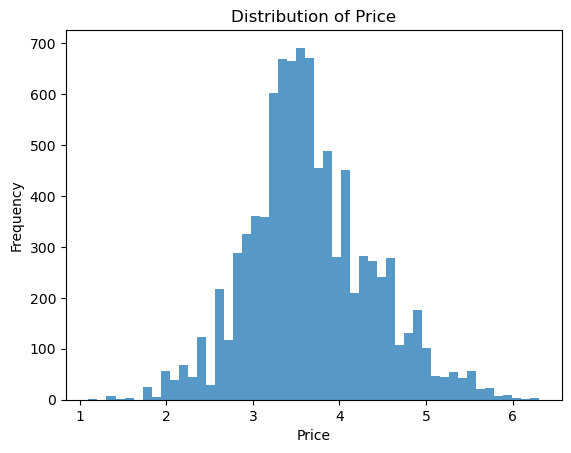

In [220]:
plt.hist(y, bins=50, alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

In [221]:
data_filtered = data.drop(columns=['id', 'name', 'details', 'how_to_use', 'ingredients', 'options', 'MarketingFlags_content', 'size', 'value_price', 'URL'])

# Splitting the features and target variable
X = data_filtered.drop(columns=['price'])
y = data_filtered['price']
y = np.log1p(y)
data_filtered.head()

,rating,number_of_reviews,love,price,MarketingFlags,online_only,exclusive,limited_edition,limited_time_offer,size_ml,...,category_Spa,category_Sponges,category_Sunscreen,category_Teeth,category_Tinted,category_Toners,category_Tweezers,category_Value,category_Wellness,category_no
0,4.0,-0.312308,-0.311626,66.0,True,1,0,0,0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.5,-0.231463,-0.318715,66.0,True,1,0,0,0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.5,-0.287605,-0.321062,180.0,True,1,0,0,0,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.5,-0.290974,-0.314020,120.0,True,1,0,0,0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.5,-0.314553,-0.359955,72.0,True,1,0,0,0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [222]:
data_filtered.shape

(9168, 415)

In [223]:
data_filtered.dtypes

rating               float64
number_of_reviews    float64
love                 float64
price                float64
MarketingFlags          bool
                      ...   
category_Toners      float64
category_Tweezers    float64
category_Value       float64
category_Wellness    float64
category_no          float64
Length: 415, dtype: object

### Hyperparameter model

In [224]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestRegressor

model_pipeline = Pipeline([
    ('model', RandomForestRegressor(random_state=42))  # Replace DecisionTreeRegressor with any model
])

param_grid = {
    'model__max_depth': [ 10, 15, 20, None],        # None
    'model__min_samples_split': [10, 20, 25],       # 10
    'model__min_samples_leaf': [2, 10],             # 2
    # 'model__max_leaf_nodes': [30, 40, 50, None],    # None
    # 'model__ccp_alpha': [0.001, 0.01]               # 0.001
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 15, 20, None],
                         'model__min_samples_leaf': [2, 10],
                         'model__min_samples_split': [10, 20, 25]},
             scoring='neg_mean_squared_error', verbose=2)

In [226]:
# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}


In [227]:
# Predict on the training set
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
# train_r2 = r2_score(y_train, y_train_pred)

# Predict on the test set
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
# test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse},Test MSE: {test_mse}")


Training MSE: 0.07859884822407046,Test MSE: 0.17671609097718427


### Visualization

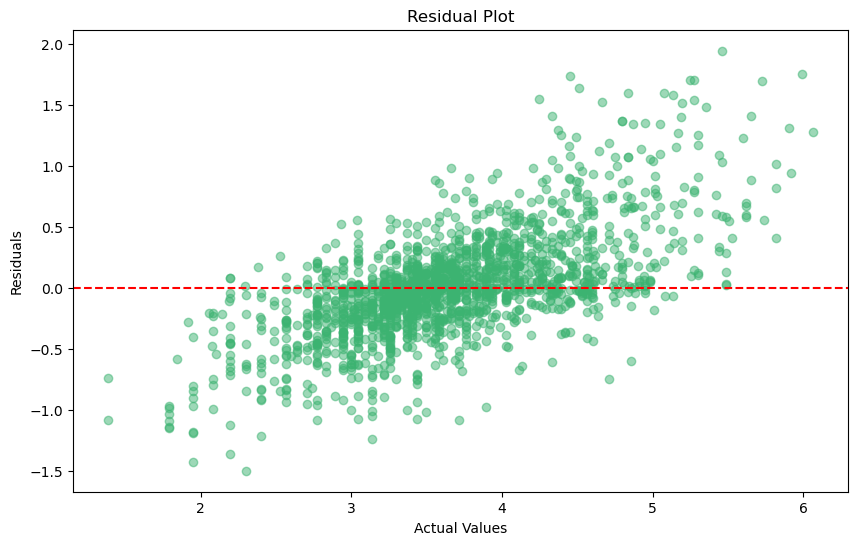

In [228]:
# Plotting Residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5,color='mediumseagreen')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

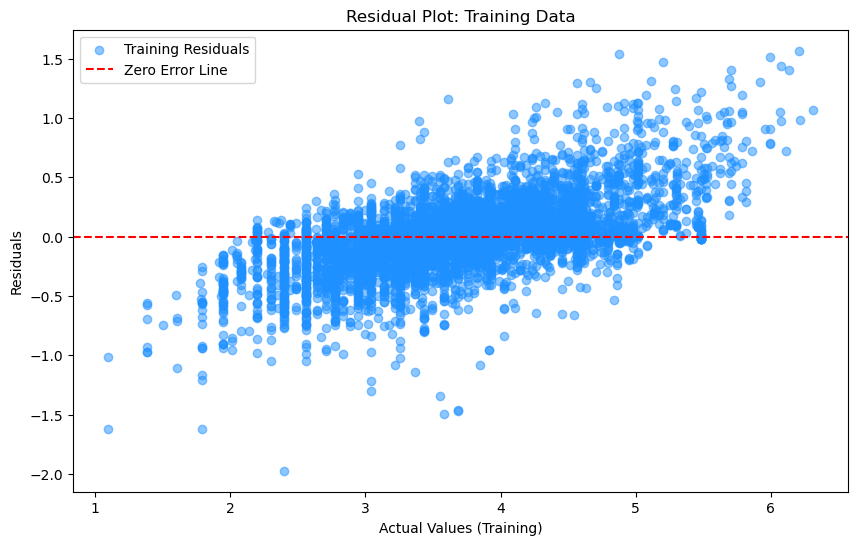

In [229]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plot training residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_residuals, alpha=0.5, color='dodgerblue', label='Training Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel('Actual Values (Training)')
plt.ylabel('Residuals')
plt.title('Residual Plot: Training Data')
plt.legend()
plt.show()

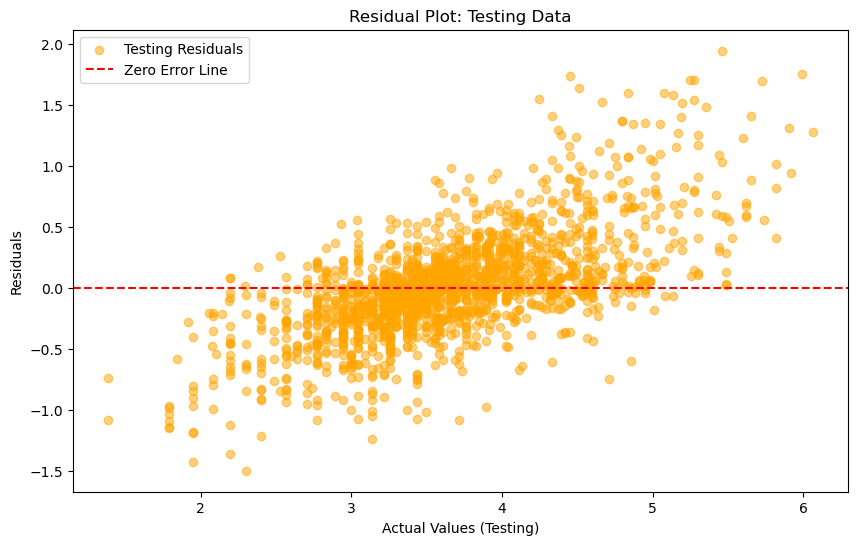

In [230]:

# Plot testing residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_residuals, alpha=0.5, color='orange', label='Testing Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel('Actual Values (Testing)')
plt.ylabel('Residuals')
plt.title('Residual Plot: Testing Data')
plt.legend()
plt.show()

#### The Actual vs Predicted Values ...

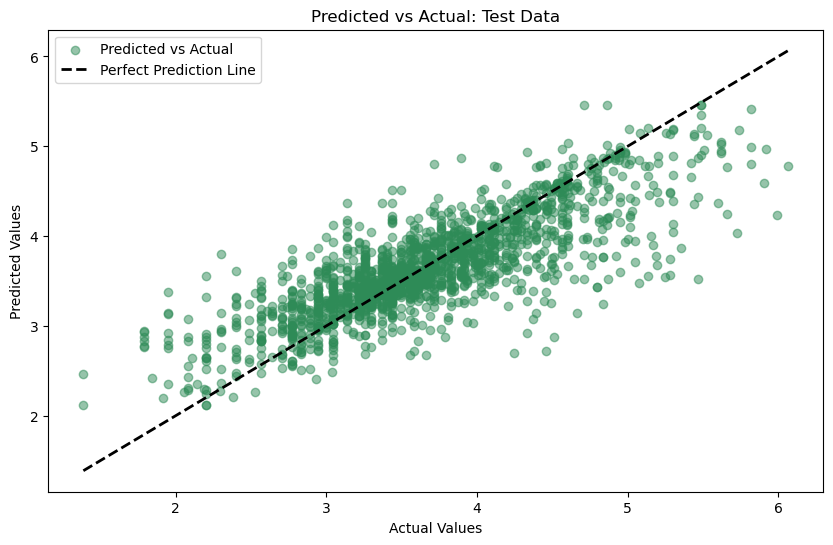

In [231]:

# Plot predictions vs actual values for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='seagreen', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Test Data')
plt.legend()
plt.show()